# The impact of water storages on flood plains

This notebook generates wofs images before and after a selected water storage structure was constructed. It is meant as a tool for studying floodplains, so only wofs data for days when there were floods are used. To only get the days when the floodplain was in flood, we linked the wofs data to stream gauge data on the time dimension and called only high-flow days. We then added functionality for the user to chose a water storage and return it's lat and lon and what date it was 50% completed. 



In [1]:
%matplotlib inline

import sys

sys.path.append('Scripts')
from datahandling import wofs_fuser

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import geopandas as gpd
import ipyleaflet as ipyl
import ipywidgets as ipyw
import json



dc = datacube.Datacube()

## Feed the code the gauge data and the waterbodies

Select a gauge from the 'Gauges' folder that is representitve of the catchment you are looking at. Then enter the shapefile containing the waterbodies. 

In [2]:
# Enter the gauges data location (.csv files only)
csv_file_location = 'Gauges/Condamine-Balonne/Culga_River_Whyenbah.csv'

# Enter the waterbodies data location (.sho files only)
shp_file_location = 'Shapefiles/Northern_Basin.shp'

Read the shapefile with geopandas and organise the data

In [3]:
#Loading the file and filtering out structures under a certain size:
gdf = gpd.read_file(shp_file_location)
gdf = gdf[gdf.area > 100000]

#Converting to EPSG4326:
gdf = gdf.to_crs({'init':'epsg:4326'}) #4326 is the tag for lat lon format

#Getting the centroid from the polygon and adding a latitude and longitude column (I found this code on the internet):
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = gdf['geometry'].centroid
x,y = [list(t) for t in zip(*map(getXY, centroidseries))]

gdf = gdf.assign(lon=x)
gdf = gdf.assign(lat=y)
gdf = gdf.rename(columns={'First50%': 'Construction_date'})
gdf['info'] = list(zip(gdf.lat, gdf.lon, gdf.Construction_date))
gdf

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,area,perimeter,UID,FID,Construction_date,geometry,lon,lat,info
3,3.150000e+05,9132.476505,r4xvmqpmf,162243,1988-03-31,"POLYGON ((146.13469 -29.97199, 146.13521 -29.9...",146.139234,-29.980673,"(-29.980672878457625, 146.13923439103164, 1988..."
5,2.387500e+05,2250.693905,r4xvn2k7w,162246,1998-03-31,"POLYGON ((146.17892 -30.05419, 146.17918 -30.0...",146.179225,-30.056597,"(-30.05659746910046, 146.1792245525888, 1998-0..."
6,3.618752e+05,18362.401686,r4xvn9t07,162247,1988-03-31,"POLYGON ((146.20034 -30.05261, 146.20139 -30.0...",146.191109,-30.050295,"(-30.05029522184124, 146.19110873164846, 1988-..."
14,3.112500e+05,11112.818253,r4xvqnw86,162255,1988-03-31,"POLYGON ((146.17467 -29.98145, 146.17493 -29.9...",146.171164,-29.978859,"(-29.97885903920209, 146.17116422849827, 1988-..."
19,3.700001e+05,8552.217344,r4xvrrhr6,162260,1988-03-31,"POLYGON ((146.22130 -29.96916, 146.22234 -29.9...",146.222966,-29.974912,"(-29.97491212632113, 146.22296587681313, 1988-..."
...,...,...,...,...,...,...,...,...,...
7744,1.306250e+05,4193.231456,r74mjxf8v,217407,1987-09-30,"POLYGON ((149.65952 -27.19920, 149.65978 -27.1...",149.659433,-27.203384,"(-27.203383876593005, 149.65943322880972, 1987..."
7776,6.256248e+05,13144.542800,r74n79272,217467,1987-12-31,"POLYGON ((149.21392 -27.01643, 149.21442 -27.0...",149.216669,-27.018940,"(-27.018940102925885, 149.21666939109318, 1987..."
7794,1.391875e+06,8101.842862,r74nnu8sx,217523,2000-09-30,"POLYGON ((149.36162 -27.03755, 149.36187 -27.0...",149.360138,-27.044799,"(-27.044798879124954, 149.36013827148295, 2000..."
7839,1.631251e+05,5727.400554,r74srcqhe,217796,1987-09-30,"POLYGON ((150.11354 -27.36308, 150.11404 -27.3...",150.114599,-27.370257,"(-27.37025666701249, 150.11459852840738, 1987-..."


## Make a map of water storages from the shapefile. Click one.

Keep in mind that the satellite data in the DEA datacube only goes back to 1987 so if the storage you select was built before that, you won't be able to make a "before" image because there's no satellite data. 

In [4]:
#Converting the data to json
data = json.loads(gdf.to_json())

map = ipyl.Map(center=[-28, 148], zoom=7)

label = ipyw.Label(layout=ipyw.Layout(width='100%'))

for feature in data['features']:
    feature['properties']['style'] = {
        'color': 'grey',
        'weight': 1,
        'fillColor': 'grey',
        'fillOpacity': 0.5
    }
layer = ipyl.GeoJSON(data=data, hover_style={'fillColor': 'red'})

def click_handler(event=None, feature=None, id=None, properties=None):
    label.value = str(properties['info'])
    
    
layer.on_hover(click_handler)
map.add_layer(layer)


ipyw.VBox([map, label])

In [12]:
label.value

"[-28.23583928722445, 148.5575058109726, '1999-12-31']"

## Calling wofs data for the lat and lon of the selected water storage on days when the stream gauge was reading high flows

In [13]:
# Take into account the lat and lon of the selected water body (feeds into the query)
info = label.value.replace("[","").replace("]","")
info = info.split(",")
lat, lon, construction_date = info
lat = float(lat)
lon = float(lon)



buffer = 15000 #This is the radius in meters around the lat, lon to display. 

#Below are the exceedence values on the x axis of the flow duration curve made from the csv file.
#Extreme flooding events sometimes mess up the delta image. Take them out by putting a limit on the x-axis. 
top_flow_percentage = 20 #recommended to set to 20, but can set to 50 if you want to call more passes
flow_percentage_limit = 0 #recommended to set to 0, but if you want to exclude extreme floods, change to 2. 

#Loading and organising guage data into a flow duration curve
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', #set up to read files from Water Data Online
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #These are just some timestamp format things
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

In [14]:
# Set up a query to call all of wofs (don't worry, we're not actually loading all of it, just calling it)
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1970-01-01', '2020-02-14'),# Change this date to match present day
         'fuse_func': wofs_fuser,
         'group_by': 'solar_day',
         'crs': 'EPSG:3577'} 

#Use Dask to load satellite data. Rather than loading images, it loads parameters only (great for linking satellite data to other datasets). 
wofs_albers = dc.load(product = 'wofs_albers', 
                      dask_chunks = {},
                      **query)

#Get the gauge data in the right format to link it to the satellite data. We will use XArray to link the data.
gauge_data_xr = gauge_data.to_xarray()

# Merging satellite data with gauge data by timestamp
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time, method='nearest')

# Here is where it takes into account that you only want the high flows
high_flow = merged_data.where((merged_data.Exceedence < top_flow_percentage) & 
                              (merged_data.Exceedence > flow_percentage_limit), drop=True)

# Get list of dates when gauge was reading high flow
date_list = high_flow.time.values

print(f'You are about to load {high_flow.time.shape[0]} satellite passes')

print(f'lat = {lat}')
print(f'lon = {lon}')

You are about to load 114 satellite passes
lat = -28.23583928722445
lon = 148.5575058109726


## Load wofs images and cloud mask them

In [15]:
# Load the passes that happened during high flows
high_flow_passes = wofs_albers.sel(time=date_list).compute()

In [16]:
# Cloudmask the high-flow satellite passes
cc = masking.make_mask(high_flow_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])
npixels_per_slice = (high_flow_passes.water.shape[1] * 
                     high_flow_passes.water.shape[2])
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
clear_high_flow_passes = high_flow_passes.water.isel(time=cloud_pixels_fraction < 0.5) #You can change 0.5 to another number if you want a stronger or weaker cloudmask

#You can un-hash these lines if you want to see a wofs summary image of this location for all time:

#wet = (clear_high_flow_passes == 128).sum(dim='time')
#dry = (clear_high_flow_passes == 0).sum(dim='time')
#clear = wet + dry
#frequency = wet / clear
#frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
#frequency = frequency.where(frequency!=0)
#frequency.plot(figsize = (10,8))

#print(f'This image is made of {high_flow_passes.time.shape[0]} satellite passes')

## Split the wofs data into before and after and display images

The Before image is made of 37 satellite passes
The After image is made of 51 satellite passes


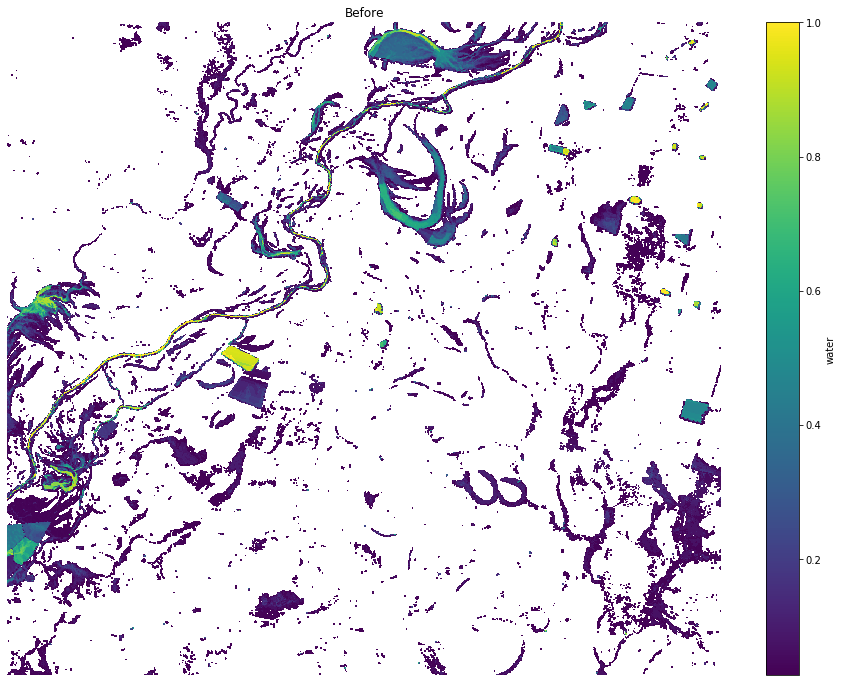

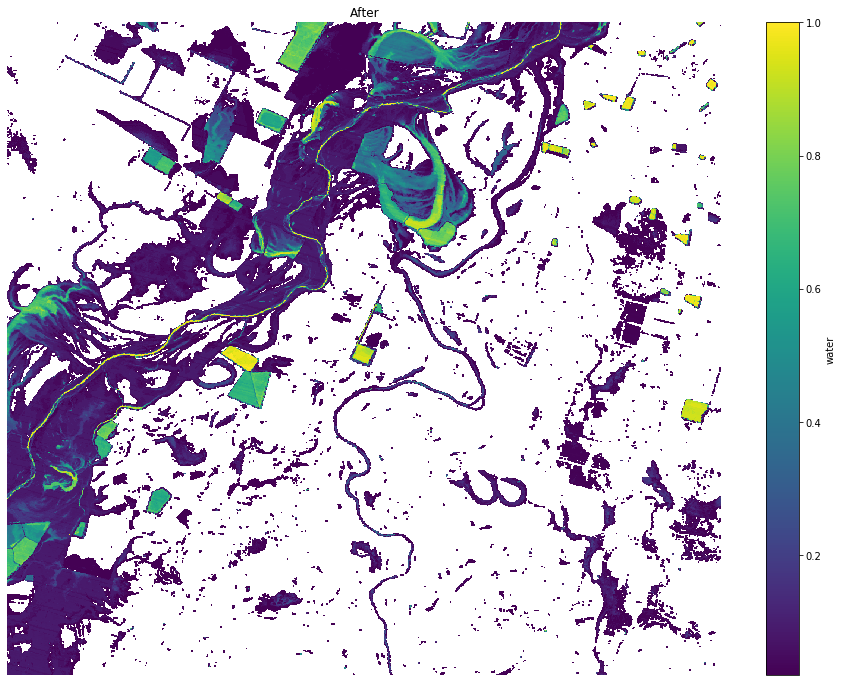

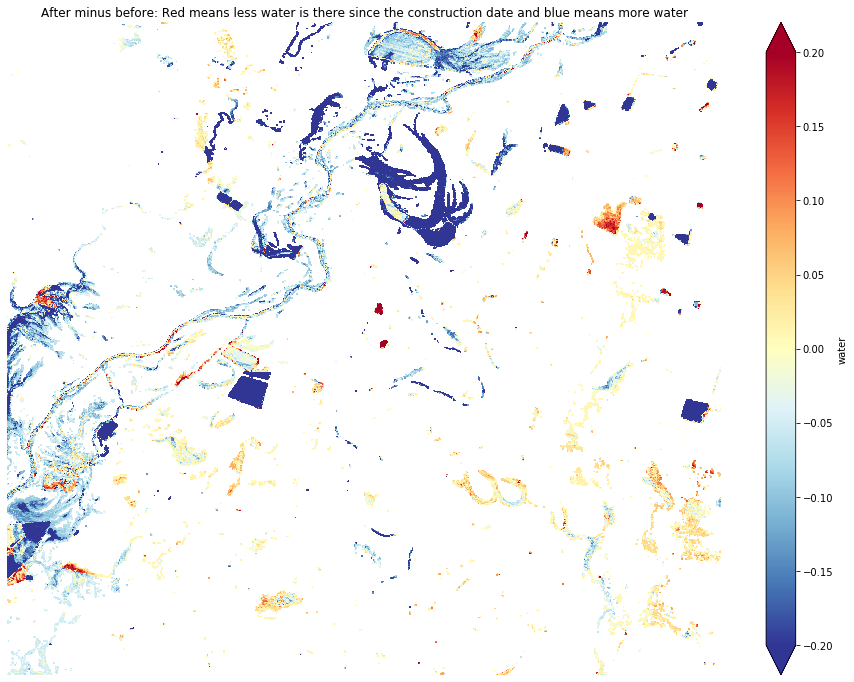

In [17]:
# Split by date into before and after legislation about floodplain harvesting
query_dates = clear_high_flow_passes

before_construction = query_dates.loc[dict(time=slice('1970-01-01', construction_date))] # Change according to date legislation became effective
after_construction = query_dates.loc[dict(time=slice(construction_date, '2020-01-01'))]

#Do you want to choose a different date?
construction_date = '1998-01-01'

print(f'The Before image is made of {before_construction.time.shape[0]} satellite passes')
print(f'The After image is made of {after_construction.time.shape[0]} satellite passes')

#Create parameters for the image
wet = (before_construction == 128).sum(dim='time')
dry = (before_construction == 0).sum(dim='time')
clear = wet + dry
frequency_before = wet / clear
frequency_before = frequency_before.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_before = frequency_before.where(frequency_before !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_before.plot(figsize = (16, 12))
plt.axis('off')
plt.title('Before')
plt.show()


#Create parameters for the image
wet = (after_construction == 128).sum(dim='time')
dry = (after_construction == 0).sum(dim='time')
clear = wet + dry
frequency_after = wet / clear
frequency_after = frequency_after.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_after = frequency_after.where(frequency_after !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_after.plot(figsize = (16, 12))
plt.axis('off')
plt.title('After')
plt.show()

delta = frequency_before - frequency_after

# Plotting the image
delta.plot(figsize = (16, 12), vmin = -0.2, vmax = 0.2, cmap = 'RdYlBu_r')
plt.axis('off')
plt.title("After minus before: Red means less water is there since the construction date and blue means more water")
plt.show()

## (optional) Check the distribution of the passes to make sure it's a good representation

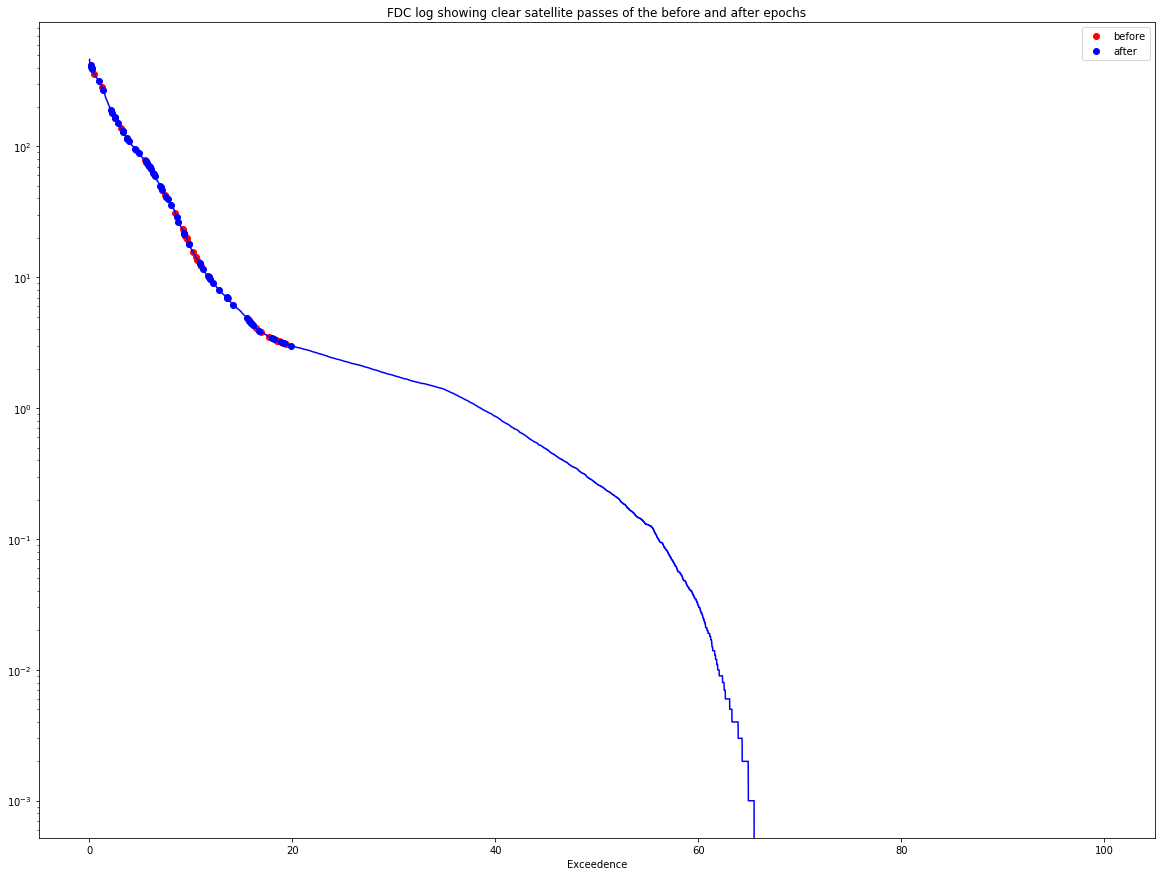

In [11]:
#Now take the clear passes and make a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_high_flow_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called time
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')

before = clear_merged_data['1980-01-10':construction_date]
after  = clear_merged_data[construction_date:]

# Plot clear satellite passes with a top 20% flowrate over a flow duration curve
ax = before.plot(x='Exceedence', marker = 'o', color = 'red', linestyle='None',
                y='Value',
                logy=True,
                title='FDC log showing clear satellite passes of the before and after epochs', figsize = (20,15))
after.plot(x='Exceedence', logy=True, y='Value', ax=ax, marker = 'o', color = 'blue', linestyle='None')
gauge_data.plot(x='Exceedence', y='Value', logy=True, ax=ax, color = 'blue')
ax.legend(["before", "after"]);

## Save wofs delta image as a .tif file

In [ ]:
# Set the output file name 
file_name = 'delta_image.tif'

# Set up the file for writing
delta_image = delta.to_dataset()
delta_image.attrs=wofs_albers.attrs

# Write GeoTIFF to a location
write_geotiff(file_name, delta_image)